<h2><b>Importing libraries</b></h2>

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<h2><b>Getting data</b></h2>

In [2]:
histVale = web.DataReader('VALE', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histAzul = web.DataReader('AZUL4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histBB = web.DataReader('BBAS3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histPetro = web.DataReader('PBR', data_source='yahoo', start="2018-01-01", end="2018-12-30")
histItau = web.DataReader('ITUB', data_source='yahoo', start="2018-01-01", end="2018-12-30")

In [3]:
historicStock = [histVale, histAzul, histBB, histPetro, histItau]

In [4]:
monthlyInflation2018 = [0.0076, 0.0007, 0.0064, 0.0057, 0.0138, 0.0187, 0.0051, 0.0070, 0.0152, 0.0089, -0.0049, -0.0108]

<h2><b>Calculating daily inflation</b></h2>

In [5]:
dayMonth30 = [4,6,9,11]
dayMonth31 = [1,3,5,7,8,10,12]
        
def calculate_daily_inflation(monthlyInflation):
    dailyInflation = []
    inflationHigh = []
    inflationLow = []
    inflationOpen = []
    inflationClose = []
    
    for index, inf in enumerate(monthlyInflation):
        if np.isin(index, dayMonth30):
            dailyInflation.append((1 + inf) ** (1/float(30)))
        elif np.isin(index, dayMonth31):
            dailyInflation.append((1 + inf) ** (1/float(31)))
        else:
            dailyInflation.append((1 + inf) ** (1/float(28)))
    
    for stock in historicStock:
        stock["Month"] = stock.index.month
        total = 1
        inflation = []
        for index, row in stock.iterrows():
            month = int(row['Month'])
            if dailyInflation[month - 1] >= 1:
                total = total * dailyInflation[month - 1]
            else:
                total = total / dailyInflation[month - 1]
            inflation.append(total)
        stock["DailyInflation"] = inflation
        
    for stock in historicStock:
        for index, row in stock.iterrows():
            inflationHigh = round(stock["High"] / stock["DailyInflation"], 2)
            inflationLow = round(stock["Low"] / stock["DailyInflation"], 2)
            inflationOpen = round(stock["Open"] / stock["DailyInflation"], 2)
            inflationClose = round(stock["Close"] / stock["DailyInflation"], 2) 
        stock["InflationHigh"] = inflationHigh
        stock["InflationLow"] = inflationLow
        stock["InflationOpen"] = inflationOpen
        stock["InflationClose"] = inflationClose

In [6]:
calculate_daily_inflation(monthlyInflation2018)

In [28]:
historicStock[0]

,High,Low,Open,Close,Volume,Adj Close,Month,DailyInflation,InflationHigh,InflationLow,...,MoneyFlowIndex,InflationTypicalPrice,Inflation1DayPositiveMoneyFlow,Inflation1DayNegativeMoneyFlow,InflationnDayPositiveMoneyFlow,InflationnDayNegativeMoneyFlow,InflationMoneyFlowRatio,InflationMoneyFlowIndex,StochasticOscillator,InflationStochasticOscillator
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,12.80,12.51,12.55,12.77,19189400.0,11.538283,1,1.000270,12.80,12.51,...,NaN,12.693333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,12.87,12.68,12.80,12.85,20449600.0,11.610567,1,1.000541,12.86,12.67,...,NaN,12.790000,2.615504e+08,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,13.09,12.82,13.03,12.83,22033100.0,11.592497,1,1.000812,13.08,12.81,...,NaN,12.903333,2.843004e+08,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,13.09,12.73,12.80,13.09,20042800.0,11.827418,1,1.001082,13.08,12.72,...,NaN,12.960000,2.597547e+08,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,13.32,13.18,13.26,13.32,17507000.0,12.035233,1,1.001353,13.30,13.16,...,NaN,13.253333,2.320261e+08,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-21,13.23,12.83,13.09,12.90,21755100.0,12.131185,12,1.073060,12.33,11.96,...,40.451825,12.103333,0.000000e+00,2.633092e+08,1.704834e+09,2.510857e+09,0.678985,40.440210,16.867455,15.625000
2018-12-24,13.03,12.59,12.82,12.60,11224100.0,11.849065,12,1.073449,12.14,11.73,...,34.998481,11.870000,0.000000e+00,1.332301e+08,1.422463e+09,2.644087e+09,0.537979,34.979597,0.628945,0.649351
2018-12-26,13.07,12.55,12.68,13.07,16587500.0,12.291053,12,1.073837,12.17,11.69,...,41.352438,12.010000,1.992159e+08,0.000000e+00,1.621679e+09,2.301870e+09,0.704505,41.331940,44.067779,41.739130


<h2><b>Calculating short and long EMAs, MACD and Signal lines</b></h2>

In [8]:
def calculate_lines():
    for stock in historicStock:
        stock["ShortEMA"] = stock["Close"].ewm(span = 12, adjust = False).mean()
        stock["LongEMA"] = stock["Close"].ewm(span = 26, adjust = False).mean()
        stock["MACD"] = stock["ShortEMA"] - stock["LongEMA"]
        stock["Signal"] = stock["MACD"].ewm(span = 9, adjust = False).mean()
        stock["InflationShortEMA"] = stock["InflationClose"].ewm(span = 12, adjust = False).mean()
        stock["InflationLongEMA"] = stock["InflationClose"].ewm(span = 26, adjust = False).mean()
        stock["InflationMACD"] = stock["InflationShortEMA"] - stock["InflationLongEMA"]
        stock["InflationSignal"] = stock["InflationMACD"].ewm(span = 9, adjust = False).mean()

In [9]:
calculate_lines()

<h2><b>Calculating Relative Strength Index (RSI)</b></h2>

In [10]:
def calculate_RSI(window):
    for stock in historicStock:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
        
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [11]:
calculate_RSI(14)

<h2><b>Function to plot RSI</b></h2>

In [12]:
def plot_rsi_close(stock, stockName, inflation=False):
    scaler = MinMaxScaler()
    stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stockScaled["RSI"].plot()
        stockScaled["Close"].plot()
    else:
        ax = stockScaled["InflationRSI"].plot()
        stockScaled["InflationClose"].plot()
    ax.axhline(y = 0.7, color = 'red')
    ax.axhline(y = 0.3, color = 'lime')
    plt.title(f'Relação RSI e Close da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Calculating Money Flow Index (MFI)</b></h2>

In [13]:
def calculate_MFI(window):
    for stock in historicStock:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))

        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [14]:
calculate_MFI(14)

<h2><b>Function to plot MFI</b></h2>

In [15]:
def plot_mfi(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["MoneyFlowIndex"].plot()
    else:
        ax = stock["InflationMoneyFlowIndex"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'MFI da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Calculating Stochastic Oscillator</b></h2>

In [16]:
def calculate_stochastic_oscillator(window):
    for stock in historicStock:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
        
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [17]:
calculate_stochastic_oscillator(14)

<h2><b>Function to plot Stochastic Oscillator</b></h2>

In [18]:
def plot_stochastic_oscillator(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["StochasticOscillator"].plot()
    else:
        ax = stock["InflationStochasticOscillator"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'Oscilador estocástico da {stockName}')
    plt.legend()
    plt.show()

<h2><b>Function to plot correlation matrix</b></h2>

In [56]:
def show_corr_matrix(stock, inflation=False):

    if inflation == False:
        corrMatrix = stock[["Close", "RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD"]].corr()
    else:
        corrMatrix = stock[["InflationClose", "InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]].corr()

    sns.heatmap(corrMatrix, annot=True)
    plt.figure(figsize = (100,100))
    plt.show()

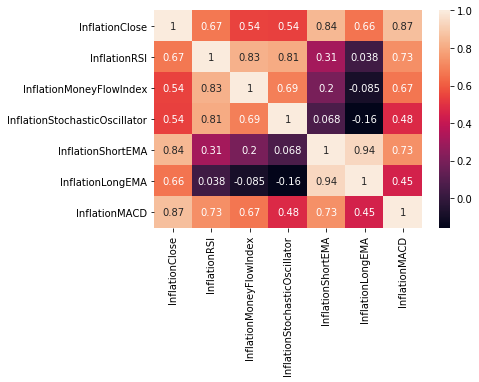

<Figure size 7200x7200 with 0 Axes>

In [58]:
show_corr_matrix(historicStock[0], True)

<h2><b>Function to predict traditional SVM</b></h2>

In [59]:
svmRegressor = svm.SVR(kernel="linear")
svmRegressorNu = svm.NuSVR(kernel="linear")

In [64]:
def predict_svm_traditional(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD"]][15:]
        stockY = stock["Close"][15:]
    else:
        stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    svmRegressor.fit(X_train, y_train)
    
    print(X_test)
    
    y_pred = svmRegressor.predict(X_test)
    print('Predicted values: ', y_pred)
    print('Testing values: ', y_test)
    print('Coefficients: \n', svmRegressor.coef_)
    
    return y_pred, y_test, y_train

In [65]:
def predict_plot_svm(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_traditional(stock, inflation)
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(y_pred, label="Prediction")
    plt.legend()
    plt.show()

[[ 7.08229426e+01  7.26129477e+01  6.31578947e+01  1.40613008e+01
   4.75543405e-01]
 [ 6.85000000e+01  6.64930910e+01  5.50420168e+01  1.40795622e+01
   4.49786850e-01]
 [ 6.65782493e+01  6.75822845e+01  5.39267016e+01  1.41242449e+01
   4.39638131e-01]
 [ 6.58536585e+01  6.76834482e+01  6.56804734e+01  1.42082073e+01
   4.50608359e-01]
 [ 5.29556650e+01  6.13528878e+01  1.02189781e+01  1.41792523e+01
   4.02216277e-01]
 [ 4.76712329e+01  5.44334614e+01  1.55555556e+01  1.41685981e+01
   3.66898079e-01]
 [ 5.51630435e+01  5.96019266e+01  3.70370370e+01  1.42041984e+01
   3.58179854e-01]
 [ 5.18950437e+01  5.93109444e+01  5.03703704e+01  1.42620140e+01
   3.61626489e-01]
 [ 5.61128527e+01  6.77101034e+01  5.11111111e+01  1.43124734e+01
   3.61003465e-01]
 [ 6.38728324e+01  7.38189620e+01  8.22222222e+01  1.44197852e+01
   3.89905615e-01]
 [ 5.28708134e+01  6.64235895e+01  2.81481481e+01  1.43982798e+01
   3.49872762e-01]
 [ 5.18337408e+01  6.16254675e+01  3.01587302e+01  1.43939290e+01

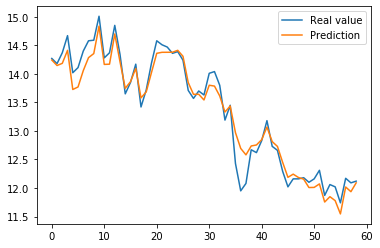

In [66]:
predict_plot_svm(historicStock[0], True)

<h2><b>Function to predict Nu SVM</b></h2>

In [23]:
def predict_svm_nu(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD"]][15:]
        stockY = stock["Close"][15:]
    else:
        stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    svmRegressorNu.fit(X_train, y_train)
    
    y_pred = svmRegressorNu.predict(X_test)
    print('Predicted values: ', y_pred)
    print('Testing values: ', y_test)
    print('Coefficients: \n', svmRegressorNu.coef_)
    
    return y_pred, y_test, y_train

In [24]:
def predict_plot_svm_nu(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_nu(stock, inflation)
    
    print('R^2 value: ', r2_score(y_test, y_pred))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    
    plt.plot(y_test, label="Real value")
    plt.plot(y_pred, label="Prediction")
    plt.legend()
    plt.show()

<h2><b>Scaling data for LSTM</b></h2>

In [25]:
scaler = MinMaxScaler()
stockScaled = []
stocksScaled = []

for stock in historicStock:
    stocksScaled.append(stock)
    
for stock in stocksScaled:
    stockScaled.append(pd.DataFrame(scaler.fit_transform(stock), columns=historicStock[0].columns))

In [26]:
def predict_LSTM(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "MoneyFlowIndex", "StochasticOscillator", "ShortEMA", "MACD"]][15:]
        stockY = stock["Close"][15:]
    else:
        stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
        stockY = stock["InflationClose"][15:]
    X = np.array(stockX)
    y = np.array(stockY)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

In [27]:
predict_LSTM(stockScaled[0])